# Problem Statement

(РУ)  
Так уж сложилось, что ребята из команды Бизнес-аналитики компании * любят перекусывать 
продукцией компании "Сибирский гурман".
Но однажды ребята задумались, а что входит в состав жареных продуктов компании "Сибирский гурман", 
и какой пищевой ценностью они обладают.
И тогда ребята попросили тебя написать скрипт по сбору данных с сайта их любимой продукции 
https://sib-gurman.ru/product/zharenye-produkty/zhara/
Результат попросили предоставить в виде таблицы, содержащей колонки:
- Наименование продукции
- Вес-упаковки, кг.
- Краткий состав,
- Пищевая ценность, ккал,
- Белки, г.,
- Жиры, г.,
- Углеводы, г.

(EN)  
It just so happened that the guys from the Business Analytics team of the * company like to snack on
products of the company "Siberian Gourmet".
But one day the guys wondered what is included in the fried products of the company "Siberian Gourmet",
and what nutritional value they have.
And then the guys asked you to write a script to collect data from the website of their favorite products
https://sib-gurman.ru/product/zharenye-produkty/zhara/
They asked to provide the result in the form of a table containing the columns:
- Product name
- Package weight, kg.
- Brief composition,
- Nutritional value, kcal,
- Proteins, g.,
- Fats, g.,
- Carbohydrates, g.

# Solution

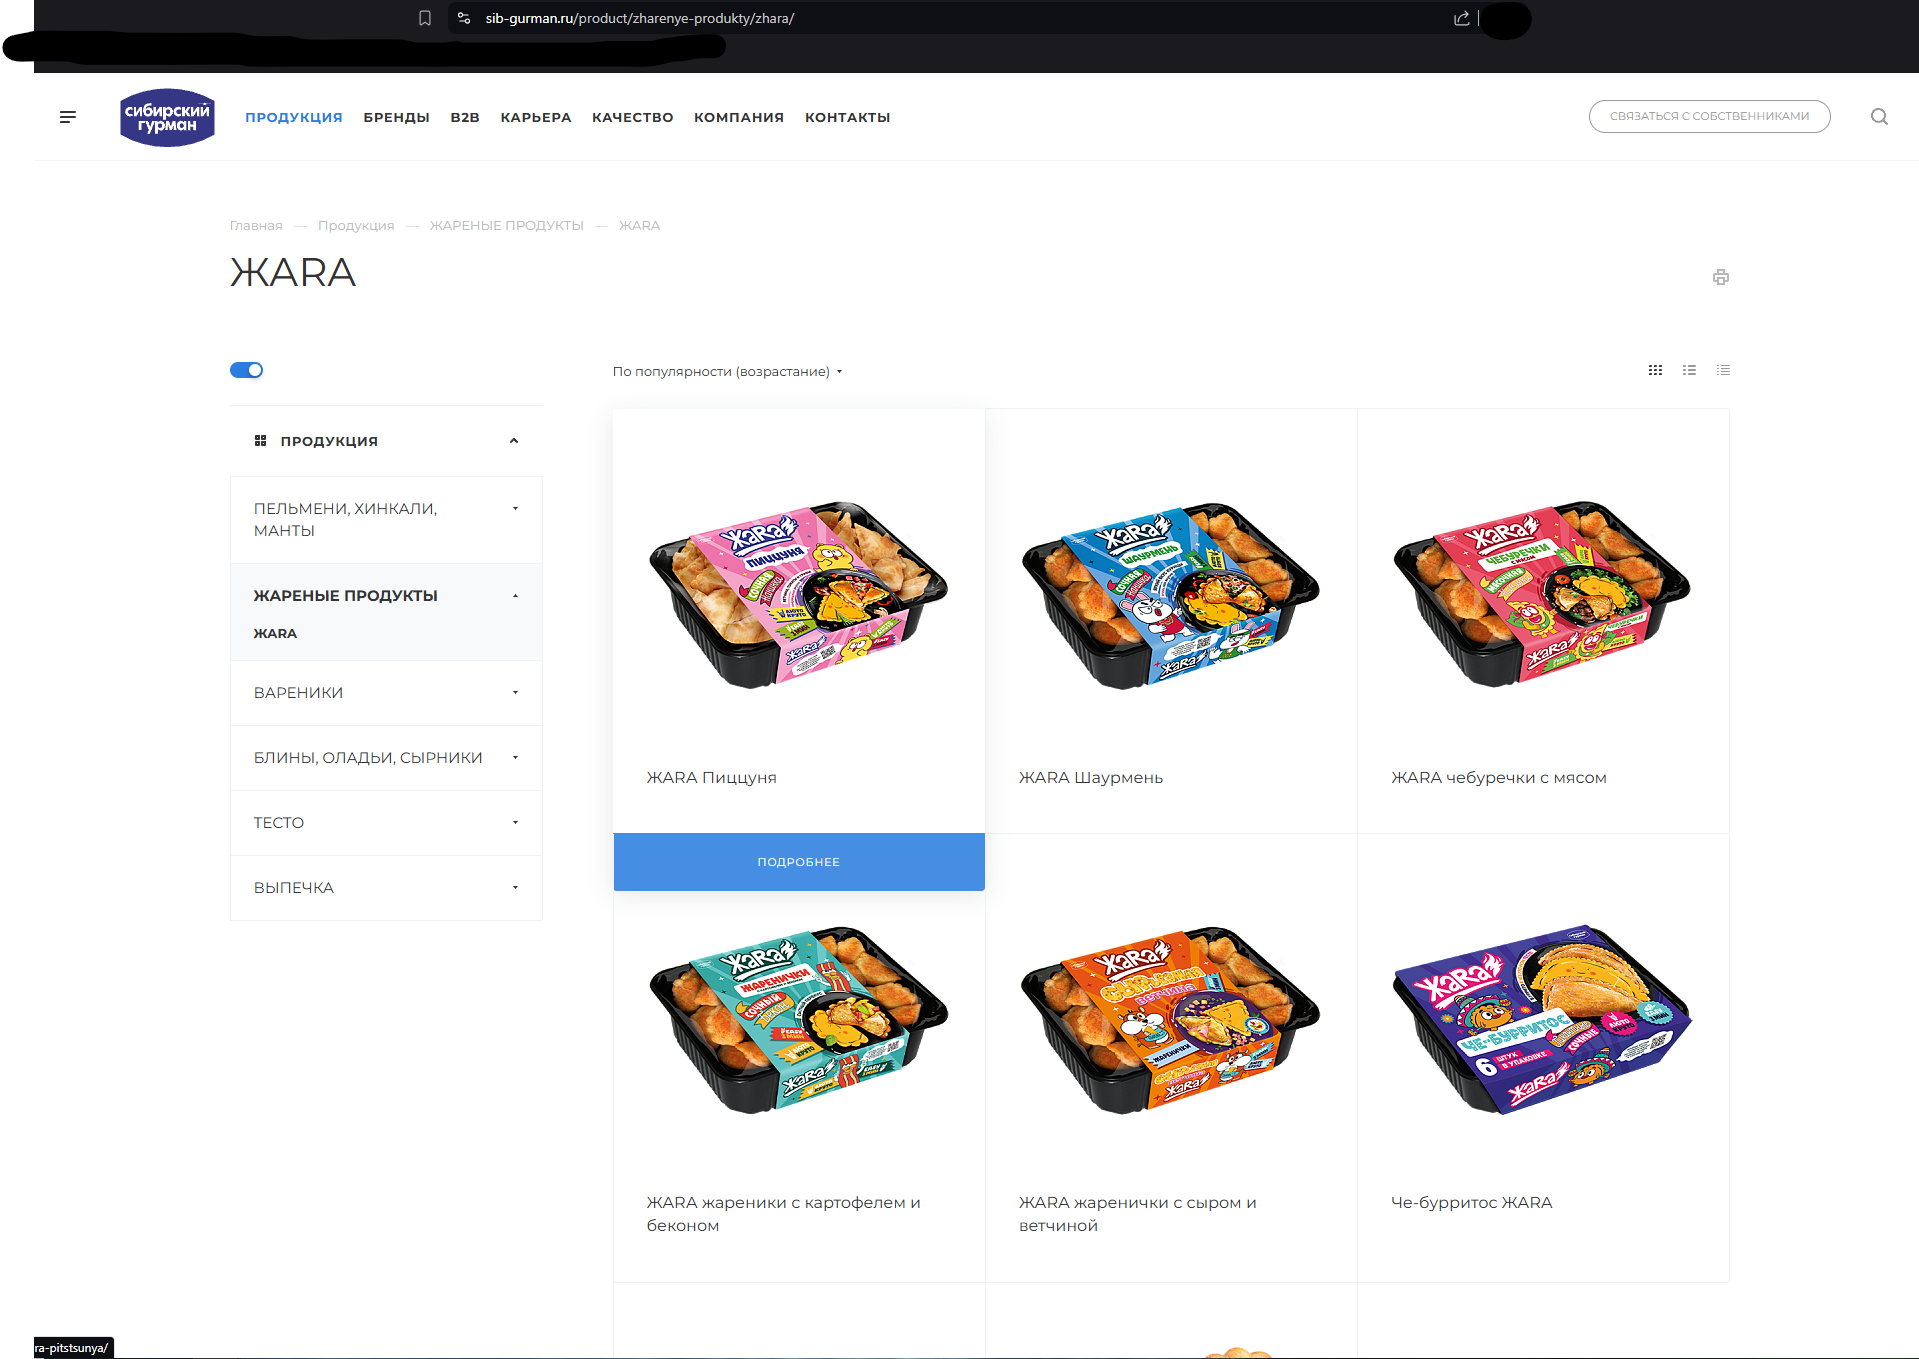

Since this website uses javascript we need to imitate real user actions and hover over 'Подробнее' button to get the needed url for future download the data from it.  
For that purpose we will use Selenium python library

## Get the links for products detailed information

In [3]:
pip install selenium

  Using cached trio_websocket-0.11.1-py3-none-any.whl.metadata (4.7 kB)
  Using cached outcome-1.3.0.post0-py2.py3-none-any.whl.metadata (2.6 kB)
  Using cached wsproto-1.2.0-py3-none-any.whl.metadata (5.6 kB)
  Using cached h11-0.14.0-py3-none-any.whl.metadata (8.2 kB)
   ---------------------------------------- 0.0/9.7 MB ? eta -:--:--
   ---------------------------------------- 0.0/9.7 MB 1.3 MB/s eta 0:00:08
   ---------------------------------------- 0.1/9.7 MB 1.3 MB/s eta 0:00:08
    --------------------------------------- 0.2/9.7 MB 1.6 MB/s eta 0:00:06
   - -------------------------------------- 0.4/9.7 MB 2.7 MB/s eta 0:00:04
   -- ------------------------------------- 0.6/9.7 MB 3.1 MB/s eta 0:00:03
   --- ------------------------------------ 0.9/9.7 MB 3.9 MB/s eta 0:00:03
   ----- ---------------------------------- 1.2/9.7 MB 4.6 MB/s eta 0:00:02
   ------ --------------------------------- 1.5/9.7 MB 5.0 MB/s eta 0:00:02
   -------- ------------------------------- 2.1/9.7 

In [5]:
from selenium import webdriver
from selenium.webdriver.common.by import By
from selenium.webdriver.common.action_chains import ActionChains
from selenium.webdriver.support.ui import WebDriverWait
from selenium.webdriver.support import expected_conditions as EC
from selenium.common.exceptions import NoSuchElementException
import time


# Function to get product links
def get_detail_links(page_url):
    driver = webdriver.Chrome() # set up the web driver
    driver.get(page_url)  # open the page URL
    time.sleep(3)  # wait for the page to load

    buttons = driver.find_elements(By.XPATH, '//a[contains(text(), "Подробнее")]') # Find all 'Подробнее' buttons
    
    urls = [] # empty list to store the URLs

    # Loop through all the buttons to hover and extract URLs
    for button in buttons:
        ActionChains(driver).move_to_element(button).perform()  # hover over the button to activate it
        time.sleep(1)  # wait for the hover action

        url = button.get_attribute('href') # get the url from the button
        if url: 
            urls.append(url)  # if the URL is not empty, add it to the list
            
    driver.quit() # Close the browser when done
    return urls



url_list = get_detail_links('https://sib-gurman.ru/product/zharenye-produkty/zhara/')
url_list

['https://sib-gurman.ru/product/zharenye-produkty/zhara/zhara-pitstsunya/',
 'https://sib-gurman.ru/product/zharenye-produkty/zhara/zhara-shaurmen/',
 'https://sib-gurman.ru/product/zharenye-produkty/zhara/zhara-cheburechki-s-myasom-lotok-0-3-8/',
 'https://sib-gurman.ru/product/zharenye-produkty/zhara/zhara-zhareniki-s-kartofelem-i-bekonom-lotok-0-3-8/',
 'https://sib-gurman.ru/product/zharenye-produkty/zhara/zhara-zharenichki-s-syrom-i-vetchinoy/',
 'https://sib-gurman.ru/product/zharenye-produkty/zhara/che-burritos-zhara/',
 'https://sib-gurman.ru/product/zharenye-produkty/zhara/zhara-chebureki-sochnye-lotok-0-24/',
 'https://sib-gurman.ru/product/zharenye-produkty/zhara/zhara-cheburechki-s-myasom-vesovye-5-0/']

## Parse the data from the links collected

In [6]:
# import libraries

from bs4 import BeautifulSoup
import requests
import pandas as pd

In [12]:
# Function to get product details from each link
def scrape_product_data(urls):
    products_data = []

    for url in urls:
        response = requests.get(url)  # send a request to the product page
        soup = BeautifulSoup(response.content, 'html.parser')  # parse the HTML content

        product_name = soup.find('h1').text.strip()  # Product name

        # dictionary to store all metrics
        metrics = {
            'url': url,
            'Наименование продукции': product_name,
        }

        # Parse the table data
        table = soup.find('table', class_='props_table') # find table
        rows = table.find_all('tr', class_='char') # find rows in table

        for row in rows:
            char_name = row.find('td', class_='char_name').get_text(strip=True)
            char_value = row.find('td', class_='char_value').get_text(strip=True)
            metrics[char_name] = char_value  # Add metric to dictionary

        products_data.append(metrics)  # append the metrics dictionary to the list

    return pd.DataFrame(products_data)

df = scrape_product_data(url_list)

## Optionally save to excel file

In [14]:
df.to_excel('Product data from sib-gurman.ru website.xlsx', index=False)